<a href="https://colab.research.google.com/github/dvera14/RPS-1/blob/main/RPS_1_Group_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
The project would focus on implementing a computer vision system that can recognize Rock, Paper, and Scissors hand gestures of a human and then suggest an optimal counter-move recommendation based on simple game-theory logic. In general, this is targeted towards building a fully automated pipeline where the user can either upload an image or click one with the webcam, and the system would identify the gesture and give the best possible strategic response.

To do this, a CNN based on ResNet-18 was trained on a dataset composed of labeled hand-gesture images. While most examples in the dataset were from the right hand, data augmentation techniques had been used (like horizontal flipping, random cropping, perspective distortion, and controlled rotation) so that the model generalizes to left and right-hand gestures during inference time. Images are transformed and resized to 224×224, then normalized and fed into the network, which outputs class probabilities for the three possible gestures.

Aside from gesture classification,we implemented a basic but effective and strong decision matrix by referencing the in class game theory. Once the model predicts the user's move, the program calculates the winning response: Paper beats Rock, Scissors beats Paper, and Rock beats Scissors. This gives the user not only the gesture recognition but also a suggested strategic action.

The final implementation has two modes of operation:

Webcam mode: captures a live frame, then passes it through the classifier.

Static image mode: the user must provide the path of the image manually.

The complete system will include a trained model, a preprocessing pipeline, and inference functions that have decision logic to perform real-time gesture detection and to choose the best move.


# METHODS (ML MODEL)
##2.1 Overview of the Approach
This project aimed to develop a machine learning system that can recognize Rock–Paper–Scissors (RPS) hand gestures from images and use game-theory principles to suggest the best counter-move. The overall system includes four key parts:

- Preparing and augmenting the data:
- Building the model (ResNet-18)
- Training the Model
- Running inference and applying decision logic

Each of these components is detailed in the following sections.

##2.2 Data Preparation
The dataset used for training included labeled images of right-hand gestures representing the three RPS choices. Since there were no left-hand samples, heavy data augmentation was applied to introduce variability and improve the model’s ability to generalize. Images were loaded using torchvision.datasets.ImageFolder, split into training and validation sets, and passed through custom transformation pipelines.

To meet the input size requirements of ResNet-18, all images were resized or cropped to 224×224 pixels.

##2.3 Data Augmentation
An advanced augmentation pipeline was set up to increase diversity and reduce the risk of overfitting. The training transformations included:

```python
train_tfms = T.Compose([
T.RandomResizedCrop(size=224, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
RandomRotate0or180(p=0.5),  # rotate image exactly 0° or 180°
T.RandomPerspective(distortion_scale=0.4, p=0.5),
T.RandomHorizontalFlip(p=0.5),
T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
T.ToTensor(),
Normalize(mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])
```


The system was designed to start with a medium grained parallelism.


###Key Design Choices:


- Horizontal flipping was used to simulate left-hand gestures, balancing the right-hand-heavy dataset.
- RandomRotate0or180 replaced standard random rotation to simulate realistic 180-degree flips only.
- Perspective distortion and random cropping helped mimic different camera angles, hand positions, and distances.
- Color jittering made the model more resistant to lighting changes.
- Validation transformations were kept minimal to avoid randomness during evaluation.


##2.4 Model Architecture


We used ResNet18 as a pretrained CNN model from ImageNet due to its strong performance on small datasets, its accuracy and its efficiency at detecting images while still being compatible with transfer learning.

###Modifications Made:

- Final layer was replaced with a 3 neuron final layer to sort the outputs into Rock, Paper, and Scissors
- Pretrained weights from ImageNet were used to have the model load the data and train faster while still keeping it extremely effective.

##2.5 Training Procedure

The model was trained using PyTorch while keeping in mind the following setup:

- Loss Function: Cross-entropy loss
- Optimizer: Stochastic Gradient Descent (SGD)
- Learning Rate: Defined in configuration notebook
- Batch Size: 32
- Epochs: Multiple, with evaluation after each
- Device: GPU or CPU, whichever is available on the system

It used early stopping to save the model with the best validation loss. In every epoch, it printed the training loss and accuracy for performance monitoring.

##2.6 Conclusion Pipeline

The system supports two modes of inference:

- Webcam Capture
  - A frame is captured using OpenCV, saved, and then passed through the model for real-time gesture recognition.
- Static Image Input:
  - They can replace “ image_path = last_frame_path” along with the path to their own image file to classify.

Once an image is loaded:

- It's processed with the same 224×224 transformation pipeline.
- It's passed through the model in evaluation mode - model.eval().
- Class probabilities are obtained by applying softmax to the model's logits.
- The class with the highest probability as the prediction.

##2.7 Decision Logic
For our decision logic we decided that we would use our in class game theory rules to determine the best outcome (win = 1 / loss= -1 / tie = 0):

- Rock→ Pick Paper
- Paper → Choose Scissors
- Scissors → Choose Rock

This allows the system to not only recognize gestures but also recommend the best response.

##2.8 Summary of Methodologies:
The pipeline brings together modern deep learning techniques, including a ResNet-18 architecture, robust gesture-specific augmentations, accelerated training using GPUs, and a straightforward decision logic based on game theory. Together, these create a reliable and interactive RPS system that can identify gestures in real time and recommend the most strategic move.


# Training the model

In [10]:
import os
import cv2 as cv
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from PIL import Image

# sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import models

# torchvision
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from tqdm.auto import tqdm

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Path to your data root
import kagglehub
DATA_DIR = kagglehub.dataset_download('sanikamal/rock-paper-scissors-dataset')
print('Data source import complete.')  # <-- change this to your path

IMG_ROOT = os.path.join(DATA_DIR, "Rock-Paper-Scissors")   # <- this has rock/paper/scissors
print("IMG_ROOT:", IMG_ROOT)
print("Class folders:", os.listdir(IMG_ROOT))
TRAIN_DIR   = os.path.join(IMG_ROOT, "train")
TEST_DIR    = os.path.join(IMG_ROOT, "test")

print("Train dir:", TRAIN_DIR)
print("Test  dir:", TEST_DIR)



100%|██████████| 452M/452M [00:03<00:00, 143MB/s]

Extracting files...


Data source import complete.
IMG_ROOT: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1/Rock-Paper-Scissors
Class folders: ['validation', 'train', 'test']
Train dir: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1/Rock-Paper-Scissors/train
Test  dir: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1/Rock-Paper-Scissors/test


In [3]:
import torchvision.transforms.functional as TF

class RandomRotate0or180(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p  # probability of applying 180° rotation

    def forward(self, img):
        if torch.rand(1).item() < self.p:
            return TF.rotate(img, 180)
        return img

train_tfms = T.Compose([
    # Random crop & zoom around the hand
    T.RandomResizedCrop(
        size=224,
        scale=(0.6, 1.0),        # zoom in a bit / full image
        ratio=(0.75, 1.33),      # slightly squished or stretched
    ),
    # Simulate different angles / viewpoints
    RandomRotate0or180(p=0.5),
    T.RandomHorizontalFlip(p=0.5),

    T.RandomPerspective(distortion_scale=0.4, p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    # Lighting / color changes
    T.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.05
    ),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Validation/test: NO crazy augmentation, just deterministic resize
val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_tfms = val_tfms


# 3. Base TRAIN dataset (NO transform here)

base_train_ds = ImageFolder(root=TRAIN_DIR, transform=None)
print("Class to index mapping:", base_train_ds.class_to_idx)


# 4. 80/20 train/val split on TRAIN_DIR

indices = list(range(len(base_train_ds)))
labels  = [base_train_ds.samples[i][1] for i in indices]  # class indices

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,           # ~80/20 split
    stratify=labels,
    random_state=42
)

print(f"Total images in TRAIN_DIR: {len(base_train_ds)}")
print(f"Train split: {len(train_idx)}, Val split: {len(val_idx)}")


# 5. Wrapper to apply different transforms

class SubsetWithTransform(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.base_dataset[self.indices[idx]]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_ds = SubsetWithTransform(base_train_ds, train_idx, train_tfms)
val_ds   = SubsetWithTransform(base_train_ds, val_idx,   val_tfms)

# TEST set comes directly from TEST_DIR with its own transform
test_ds  = ImageFolder(root=TEST_DIR, transform=test_tfms)


# 6. Dataloaders

batch_size = 32

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=2, persistent_workers=True, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, persistent_workers=True, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, persistent_workers=True, pin_memory=True
)


# 7. Quick sanity check

images, labels = next(iter(train_loader))
print("Train batch shape:", images.shape, "Labels sample:", labels[:8])
print("Num test images:", len(test_ds))

Class to index mapping: {'paper': 0, 'rock': 1, 'scissors': 2}
Total images in TRAIN_DIR: 2520
Train split: 2016, Val split: 504
Train batch shape: torch.Size([32, 3, 224, 224]) Labels sample: tensor([1, 2, 0, 2, 1, 1, 0, 1])
Num test images: 372


In [4]:

from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# First freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last residual block + final FC layer
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Only optimize the unfrozen params (layer4 + fc)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15 # adjust as needed

history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
best_val_loss = float("inf")
best_model_path = "rps_best_model.pth"

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # ---- Train ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)              # [batch, 3]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---- Validate ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Save best model
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        print(f"New best model saved (val_loss = {best_val_loss:.4f})")

    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.4f}")



Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0076)
Train Loss: 0.2297  Train Acc: 0.9246
Val   Loss: 0.0076  Val   Acc: 1.0000

Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0061)
Train Loss: 0.0413  Train Acc: 0.9896
Val   Loss: 0.0061  Val   Acc: 1.0000

Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0026)
Train Loss: 0.0196  Train Acc: 0.9955
Val   Loss: 0.0026  Val   Acc: 1.0000

Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0182  Train Acc: 0.9945
Val   Loss: 0.0028  Val   Acc: 0.9980

Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0005)
Train Loss: 0.0131  Train Acc: 0.9980
Val   Loss: 0.0005  Val   Acc: 1.0000

Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0131  Train Acc: 0.9965
Val   Loss: 0.0007  Val   Acc: 1.0000

Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0149  Train Acc: 0.9940
Val   Loss: 0.0008  Val   Acc: 1.0000

Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0147  Train Acc: 0.9950
Val   Loss: 0.0019  Val   Acc: 1.0000

Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0116  Train Acc: 0.9980
Val   Loss: 0.0009  Val   Acc: 1.0000

Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0184  Train Acc: 0.9936
Val   Loss: 0.0008  Val   Acc: 1.0000

Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

New best model saved (val_loss = 0.0002)
Train Loss: 0.0112  Train Acc: 0.9955
Val   Loss: 0.0002  Val   Acc: 1.0000

Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0072  Train Acc: 0.9995
Val   Loss: 0.0003  Val   Acc: 1.0000

Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0108  Train Acc: 0.9960
Val   Loss: 0.0002  Val   Acc: 1.0000

Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0101  Train Acc: 0.9960
Val   Loss: 0.0002  Val   Acc: 1.0000

Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0036  Train Acc: 1.0000
Val   Loss: 0.0003  Val   Acc: 1.0000


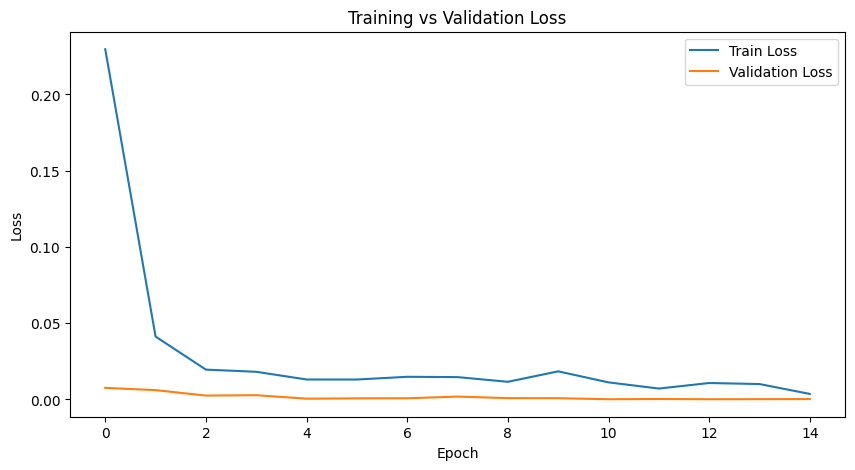

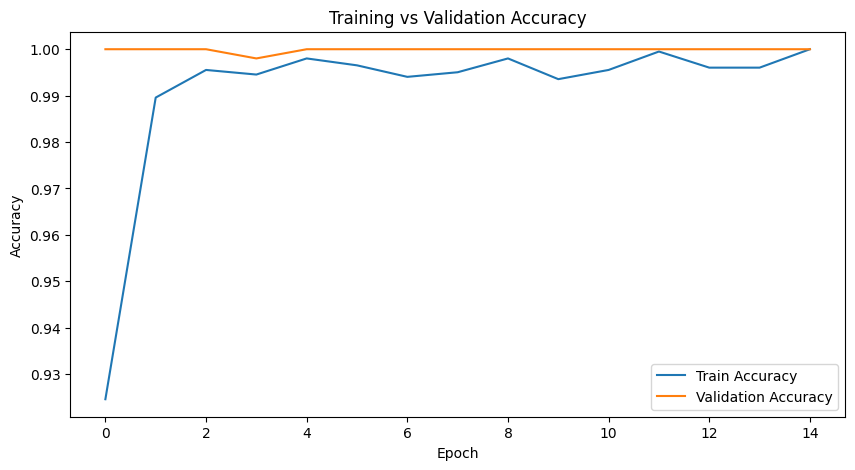

In [6]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history["acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Validation performance (macro):
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

Classification report:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       168
        rock       1.00      1.00      1.00       168
    scissors       1.00      1.00      1.00       168

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504



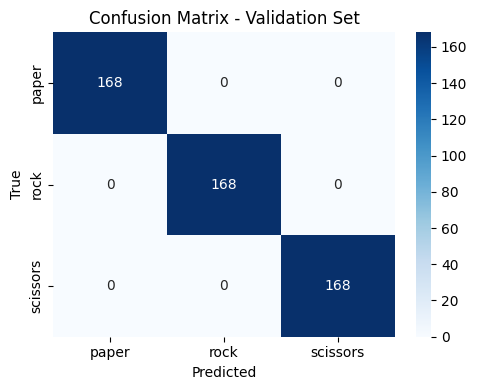


Macro AUC (OVR): 1.0000


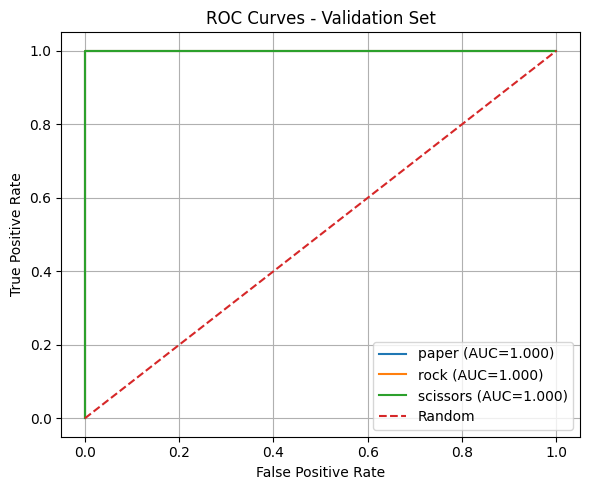

In [7]:

# ---------- Load best model ----------
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds  = []
all_probs  = []   # <-- softmax scores

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs   = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds  = np.concatenate(all_preds)
all_probs  = np.concatenate(all_probs)

# ---------- Metrics ----------
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="macro")
rec  = recall_score(all_labels, all_preds, average="macro")
f1   = f1_score(all_labels, all_preds, average="macro")

print("Validation performance (macro):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Correct class names
idx_to_class = {v: k for k, v in base_train_ds.class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# ---------- ROC & AUC ----------
n_classes = all_probs.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(6, 5))

for i in range(n_classes):
    y_true = (all_labels == i).astype(int)
    y_score = all_probs[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = roc_auc_score(y_true, y_score)

    plt.plot(fpr[i], tpr[i], label=f"{idx_to_class[i]} (AUC={roc_auc[i]:.3f})")


macro_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
print(f"\nMacro AUC (OVR): {macro_auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()






# RESULTS

# Image Processing

**EXAMPLE FOR USING WEBCAM ON YOUR PERSONAL COMPUTER**
Python executable code that will open up your webcam and take an image when you press 'q'.

Copy the code below into a python file


*   Create virtual environnement
*   Install cv2
*   Run the file
*   press q to take picture



In [ ]:
import cv2 as cv
import sys
import os

output_folder = 'images'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Open the default camera
cam = cv.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

last_frame = None

print("Press 'q' to take snapshot.")

while True:
    ret, frame = cam.read()

    # Write the frame to the output file
    out.write(frame)

    # Display the captured frame
    cv.imshow('Camera', frame)

    last_frame = frame

    # Press 'q' to exit the loop
    if cv.waitKey(1) == ord('q'):
        break

if last_frame is not None:
    # Save the last frame in the 'images' folder
    last_frame_path = os.path.join(output_folder, 'last_frame.jpg')
    cv.imwrite(last_frame_path, last_frame)
    print(f"Snapshot saved as '{last_frame_path}'")

# Release the capture and writer objects
cam.release()
out.release()
cv.destroyAllWindows()







Press 'q' to take snapshot.


DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


In [ ]:
#Dependencies

from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv

#UPLOAD SAMPLE IMAGES
images folder will be created and inside will be the original image split into 4 parts

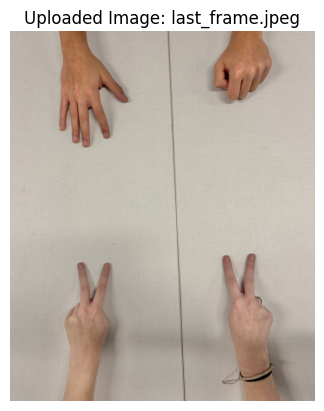

Successfully loaded image from last_frame.jpeg. Image size: (4249, 5155), format: JPEG


In [8]:

# Replace 'your_image_file.jpg' with the actual path to your uploaded image file
last_frame_path = 'last_frame.jpeg'

output_folder = 'images'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)



try:
    img = Image.open(last_frame_path)
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title(f'Uploaded Image: {last_frame_path}')
    plt.show()
    print(f'Successfully loaded image from {last_frame_path}. Image size: {img.size}, format: {img.format}')
except FileNotFoundError:
    print(f"Error: The file '{last_frame_path}' was not found. Please ensure the file is uploaded and the path is correct.")
except Exception as e:
    print(f"An error occurred while opening the image: {e}")


In [11]:
# Read the saved image from the 'images' folder
img = cv.imread(last_frame_path)

if img is None:
    print("Could not read the image.")
    sys.exit()

# Splitting the image into 4 parts
h, w, channels = img.shape

half_width = w // 2
half_height = h // 2

# Splitting into 4 parts. These are numpy 2D arrays
top_left = img[:half_height, :half_width]
top_right = img[:half_height, half_width:]
bottom_left = img[half_height:, :half_width]
bottom_right = img[half_height:, half_width:]

# Save the split images in the 'images' folder
cv.imwrite(os.path.join(output_folder, 'top_left.jpg'), top_left)
cv.imwrite(os.path.join(output_folder, 'top_right.jpg'), top_right)
cv.imwrite(os.path.join(output_folder, 'bottom_left.jpg'), bottom_left)
cv.imwrite(os.path.join(output_folder, 'bottom_right.jpg'), bottom_right)

print("Saved: top_left.jpg, top_right.jpg, bottom_left.jpg, bottom_right.jpg")

Saved: top_left.jpg, top_right.jpg, bottom_left.jpg, bottom_right.jpg


In [12]:
#Image paths

top_left_path = "/content/images/top_left.jpg"
top_right_path = "/content/images/top_right.jpg"
bottom_left_path = "/content/images/bottom_left.jpg"
bottom_right_path = "/content/images/bottom_right.jpg"

# Loading the model and predicting the classes

idx_to_class: {0: 'paper', 1: 'rock', 2: 'scissors'}

Predicted class: paper (confidence = 0.756)
Class probabilities:
  paper    : 0.756
  rock     : 0.065
  scissors : 0.178

Predicted class: rock (confidence = 1.000)
Class probabilities:
  paper    : 0.000
  rock     : 1.000
  scissors : 0.000

Predicted class: scissors (confidence = 0.999)
Class probabilities:
  paper    : 0.000
  rock     : 0.001
  scissors : 0.999

Predicted class: scissors (confidence = 1.000)
Class probabilities:
  paper    : 0.000
  rock     : 0.000
  scissors : 1.000


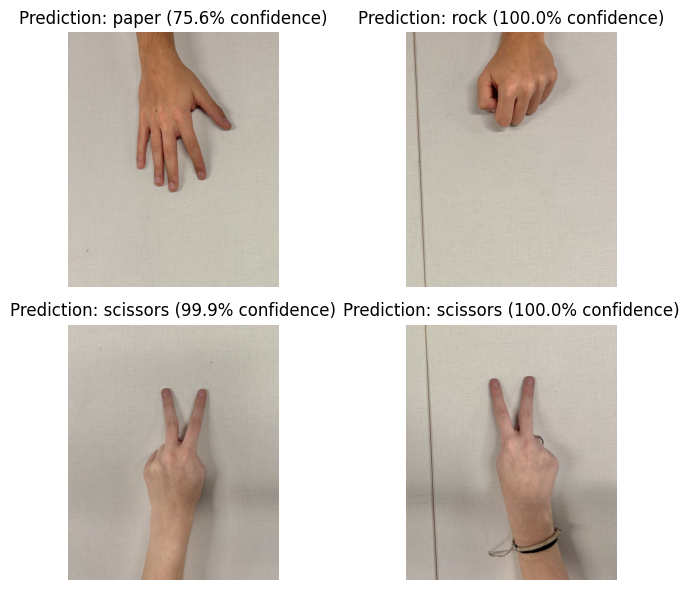

In [13]:

# Class mapping from the *training* dataset
idx_to_class = {v: k for k, v in base_train_ds.class_to_idx.items()}
print("idx_to_class:", idx_to_class)

# Use the same transforms as validation
infer_tfms = val_tfms

 # 3. Load best weights (val-loss best) and eval mode
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

def predict_hand_image(image_path, show_probs=True):
    """
    Load an image from `image_path`, run it through the trained model,
    and return (PIL image, predicted class name, confidence, probs array).
    """
    # 1. Load image
    img = Image.open(image_path).convert("RGB")

    # 2. Apply transforms and add batch dimension
    x = infer_tfms(img).unsqueeze(0).to(device)   # [1, 3, 224, 224]

    # 4. Forward pass
    with torch.no_grad():
        logits = model(x)                         # [1, 3]
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    # 5. Get prediction + confidence
    pred_idx = int(np.argmax(probs))
    pred_class = idx_to_class[pred_idx]
    confidence = probs[pred_idx]

    if show_probs:
        print(f"\nPredicted class: {pred_class} (confidence = {confidence:.3f})")
        print("Class probabilities:")
        for i, class_name in idx_to_class.items():
            print(f"  {class_name:9s}: {probs[i]:.3f}")

    return img, pred_class, confidence, probs

# ---- Call the function and plot ----
img, pred_class, conf, probs = predict_hand_image(top_left_path, show_probs=True)
img2, pred_class2, conf2, probs2 = predict_hand_image(top_right_path, show_probs=True)
img3, pred_class3, conf3, probs3 = predict_hand_image(bottom_left_path, show_probs=True)
img4, pred_class4, conf4, probs4 = predict_hand_image(bottom_right_path, show_probs=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Top left Hand
axes[0, 0].imshow(img)
axes[0, 0].axis("off")
axes[0, 0].set_title(f"Prediction: {pred_class} ({conf:.1%} confidence)")

# Top right Hand
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")
axes[0, 1].set_title(f"Prediction: {pred_class2} ({conf2:.1%} confidence)")

# Bottom left_hand
axes[1, 0].imshow(img3)
axes[1, 0].axis("off")
axes[1, 0].set_title(f"Prediction: {pred_class3} ({conf3:.1%} confidence)")


# Bottom right Hand
axes[1, 1].imshow(img4)
axes[1, 1].axis("off")
axes[1, 1].set_title(f"Prediction: {pred_class4} ({conf4:.1%} confidence)")



plt.tight_layout()
plt.show()

# Decision
The following function implements the Minimax Strategy. It evaluates the "safety level" of keeping each hand. We assume the opponent is rational and will choose the counter-move that minimizes our payoff.


In [14]:
pred_classes = [pred_class, pred_class2, pred_class3, pred_class4]
print(pred_classes)

def get_winner(p1, p2):
  if p1 == p2:
    return 0  # Tie
  elif (p1 == "rock" and p2 == "scissors") or \
       (p1 == "scissors" and p2 == "paper") or \
       (p1 == "paper" and p2 == "rock"):
    return 1  # p1 wins
  else:
    return -1 # p2 wins

def decision(predictions):
  # Assuming predictions[0] is player 1's left hand and predictions[1] is player 1's right hand
  # Assuming predictions[2] is player 2's left hand and predictions[3] is player 2's right hand

  # Evaluate player 1's left hand against player 2's hands
  score_p1_left = get_winner(predictions[2], predictions[0]) + get_winner(predictions[2], predictions[1])

  # Evaluate player 1's right hand against player 2's hands
  score_p1_right = get_winner(predictions[3], predictions[0]) + get_winner(predictions[3], predictions[1])

  if score_p1_left > score_p1_right:
    return "keep left hand"
  elif score_p1_right > score_p1_left:
    return "keep right hand"
  else:
    return "It's a tie or equally optimal choice"

print(decision(pred_classes))

['paper', 'rock', 'scissors', 'scissors']
It's a tie or equally optimal choice


# 4. Discussion

## 4.1 Justification of Approach: Transfer Learning
For the perception layer of our project, we employed **Transfer Learning** using the **ResNet18** architecture, pre-trained on the ImageNet dataset. We chose ResNet18 because it offers an excellent balance between performance (high accuracy) and computational efficiency (low inference latency), which is critical for a real-time game assistant.

Rather than training a Convolutional Neural Network (CNN) from scratch—which would require thousands of images and significant computational power—we utilized the pre-learned feature extractors of ResNet.
* **Implementation:** We initially froze the early layers of the network (which detect basic edges and textures) and only unfroze the final residual block (`layer4`) and the fully connected layer (`fc`).
* **Reasoning:** This allowed us to fine-tune the model specifically for hand gestures without destroying the robust visual features learned from ImageNet.

## 4.2 Challenges and Solutions: The "Opponent" Perspective
A major challenge in RPS-1 is that the opponent sits across the table, meaning their hands appear inverted (rotated 180 degrees) relative to the training data. Standard datasets typically only include upright hands.

Instead of writing a manual script to rotate images during the game, we solved this **algorithmically through the training pipeline**.
* **Solution:** We implemented a custom data augmentation class, `RandomRotate0or180`. During training, this module randomly rotates input images by exactly 180 degrees with a probability of $p=0.5$.
* **Result:** By exposing the model to both upright and inverted examples during the learning phase, the network learned to classify hand shapes regardless of whether they belonged to the player (upright) or the opponent (inverted). This made our model "viewpoint invariant" regarding the two players.

## 4.3 Addressing Dataset Bias: The "Handedness" Problem
During early testing, we observed a performance discrepancy: the model classified right hands with high confidence but struggled with left hands. An analysis of our dataset revealed a class imbalance; the training images were predominantly right hands.

* **Solution:** We utilized `transforms.RandomHorizontalFlip(p=0.5)` in our training transformation pipeline.
* **Reasoning:** Geometrically, a left hand looks identical to a horizontally flipped right hand. By synthetically generating these mirrored images during training, we effectively doubled our dataset size and removed the handedness bias. This allowed the model to generalize to both hands without needing to collect new data.

## 4.4 Robustness via Augmentation
To ensure the model would work in various environments (not just the room where we collected data), we applied a suite of robust augmentations:
1.  **RandomResizedCrop:** Simulates hands being at different distances (zooming in/out).
2.  **ColorJitter:** randomly adjusts brightness and contrast, ensuring the model works in different lighting conditions.
3.  **RandomPerspective:** Simulates the camera being viewed from slightly different angles, rather than a perfect top-down view.
## 4.3 Societal and Economic Implications
While this project focuses on a recreational game, the underlying technology has broader implications for **Human-Computer Interaction (HCI)**. The ability of a system to perceive a user's non-verbal inputs (gestures), understand the context (the game state), and offer real-time decision support is applicable to high-stakes fields. For example, similar systems could be used in industrial collaborative robotics, where a robot must recognize a worker's hand signals and orientation to safely hand over tools, or in surgical training, where an AI analyzes a student's hand positioning and suggests corrections in real-time.

#Conclusion
This project created a machine-learning framework capable of identifying Rock–Paper–Scissors hand signals and suggesting the optimal counteraction based on basic game-theory concepts. By training a crafted augmentation pipeline alongside a modified ResNet-18 architecture strong generalization was achieved despite the dataset containing solely right-hand samples. Various methods such as flipping, regulated rotation and perspective distortion ensured the classifier could reliably interpret real-world changes, in hand placement lighting conditions and angles.

Apart from recognizing gestures the built-in automated decision logic converts this system from a static classifier to an interactive strategic advisor. By using webcam input or still images users can swiftly receive the gesture along with the best move to secure the round. This demonstrates how deep learning, in computer vision can serve purposes beyond prediction extending to real-time decision-making tasks.

Our project thoroughly demonstrates how the complete machine learning workflow proceeds, from our image pre-processing, to the training of the model, through to the testing, then finally to the usage cases and playing against it. While an increase in dataset diversity could slightly boost the project's performance and confidence in its selections. The current revision of the project allows for future advancements while fulfilling all objectives and performing outstanding.
